# Lights model tutorial

In [2]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
#from tick.plot import plot_point_process
from lights.simulation import SimuJointLongitudinalSurvival
from lights.base.utils import heatmap, annotate_heatmap, gompertz_pdf, \
                              gompertz_survival, visualize_vect_learning
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from IPython.display import Markdown, display
from scipy.stats import beta
%matplotlib inline

def printmd(string):
    display(Markdown(string))

ModuleNotFoundError: No module named 'lights'

In [2]:
## Load configuration
import json
with open('experiment.json') as f:
    conf = json.load(f)
print(json.dumps(conf, indent=4))

{
    "l_pen_SGL": 0.01,
    "l_pen_EN": 0.01
}


## Generate data

In [3]:
n_long_features = 3
n_time_indep_features = 5
simu = SimuJointLongitudinalSurvival(seed=123, n_long_features=n_long_features, n_samples=400
                                     ,n_time_indep_features = n_time_indep_features)
X, Y, T, delta = simu.simulate()

printmd("\nLevel of censoring: **%.2f%%**" % (100*(1 - delta.mean())))

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.91e+00 seconds.



Level of censoring: **39.00%**

### Visualize parameter vectors
We generate survival times with a risk model of the form
$$\begin{align*}
\lambda_i(t|G_i = k) &= \lambda_0(t) \exp \Big\{ x_i^\top \xi + \sum_{l=1}^L \gamma_{k,1}^l (\beta_{k,1}^l + \beta_{k,2}^l t + b_{i,1}^l + b_{i,2}^l t) + (\gamma_{k,2,1}^l b_{i,1}^l + \gamma_{k,2,2}^l b_{i,2}^l) + \gamma_{k,3}^l (\beta_{k,2}^l + b_{i,2}^l) \Big\} \\
&= \lambda_0(t) \exp \big\{ \iota_{i,k,1} + \iota_{i,k,2} t \big\}
\end{align*}$$

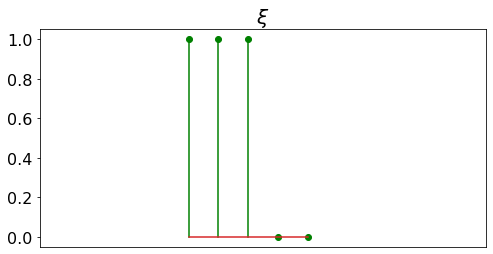

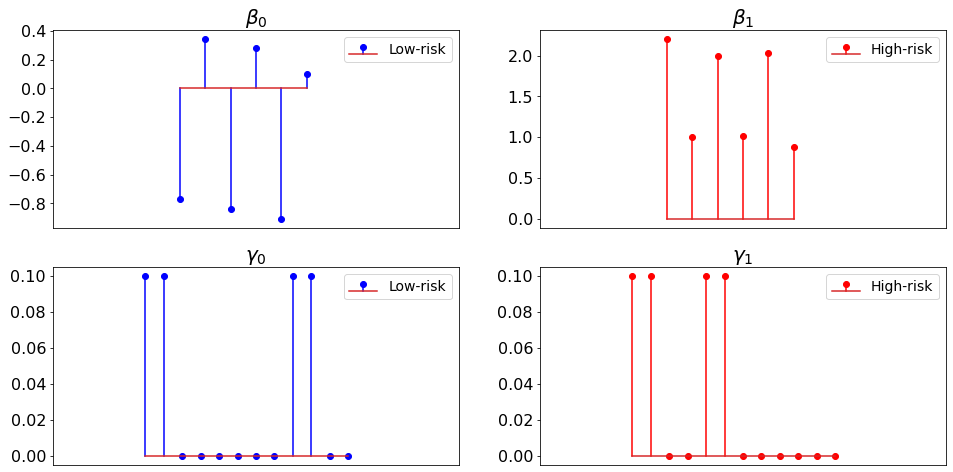

In [4]:
xi, betas, gammas = simu.time_indep_coeffs, simu.fixed_effect_coeffs, simu.asso_coeffs

fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(xi, linefmt='g-', markerfmt='go')
ax.set_xlim([-5, len(xi) + 5])
ax.set_title(r"$\xi$", fontsize=fontsize+4)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

fig = plt.figure(figsize=(16, 8))
names, colors, labels = ['beta', 'gamma'], ['b', 'r'], ['Low-risk', 'High-risk']
j = 1

for i, vectors in enumerate([betas, gammas]):
    for k in [0, 1]:
        name = names[i]
        ax = fig.add_subplot(2,2,j)
        j += 1
        ax.stem(vectors[k], linefmt='%s-' % colors[k], 
                markerfmt='%so' % colors[k], label=labels[k])
        ax.set_xlim([-5, len(vectors[k]) + 5])
        ax.set_title(r"$\%s_%s$" % (name, k), fontsize=fontsize+4)
        plt.yticks(fontsize=fontsize)
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.legend(fontsize=fontsize-2)
plt.show()

### Visualize simulated times

We choose a Gompertz distribution for the baseline, that is
$$\lambda_0(t) = \kappa_1 \kappa_2 \exp(\kappa_2t)$$
with $\kappa_1 > 0$ and $\kappa_2 \in R$ the scale and shape parameters respectively.

kappa_1=0.001, kappa_2=0.1


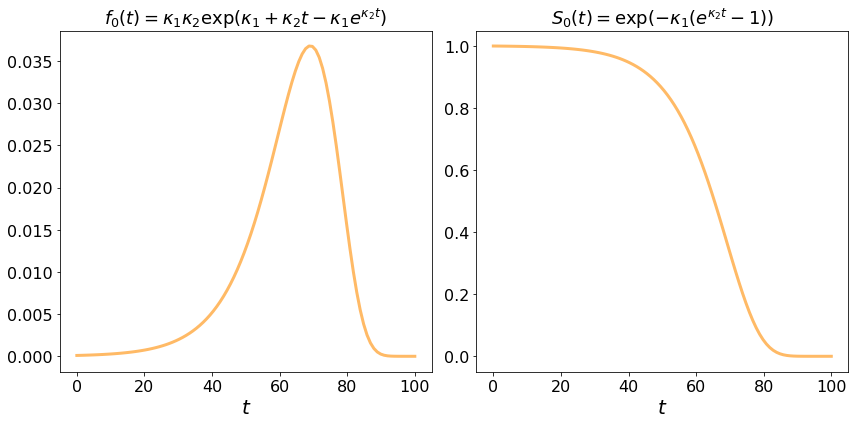

In [5]:
scale, shape = simu.scale, simu.shape
print("kappa_1=%s, kappa_2=%s" % (scale, shape))

fig = plt.figure(figsize=(12, 6))
# Density function plot
ax = fig.add_subplot(121)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_pdf(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$f_0(t) = \kappa_1 \kappa_2 \exp (\kappa_1 + \kappa_2 t -\kappa_1 e^{\kappa_2 t})$", 
          size=fontsize+2)

# Survival function plot
ax = fig.add_subplot(122)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_survival(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$S_0(t) = \exp (-\kappa_1 (e^{\kappa_2 t} - 1) )$", size=fontsize+2)

fig.tight_layout()
plt.show()

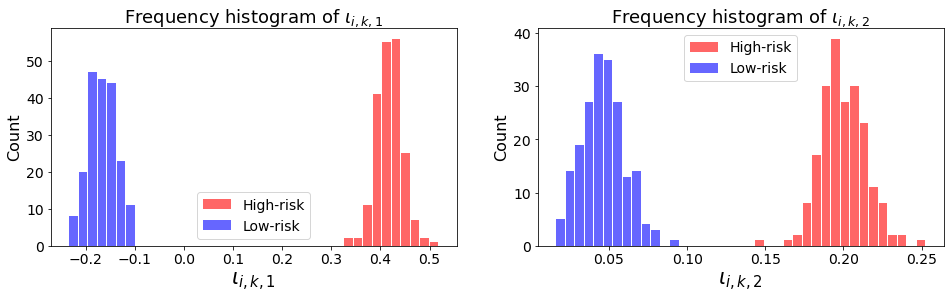

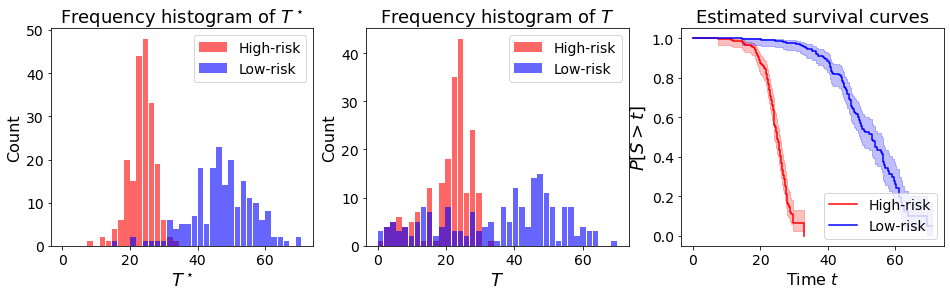

In [6]:
fig = plt.figure(figsize=(16, 4))
iotas = simu.iotas
for i in [1, 2]:
    ax = fig.add_subplot(1,2,i)
    iota_0i, iota_1i = iotas[i]
    all_iota = list(iota_0i) + list(iota_1i)
    mini, maxi = min(all_iota), max(all_iota)
    bins = np.linspace(mini, maxi, 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(iota_1i, **kwargs, color='r', label='High-risk')
    plt.hist(iota_0i, **kwargs, color='b', label='Low-risk')
    plt.xlabel(r"$\iota_{i,k,%s}$" % i, size=fontsize + 5)
    plt.ylabel("Count", size=fontsize)
    plt.legend(fontsize=fontsize-2)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$\iota_{i,k,%s}$' % i, size=fontsize+2)
plt.show()

fig = plt.figure(figsize=(16, 4))
G = simu.latent_class
T_star = simu.event_times
times, labels = [T_star, T], ['T^\star', 'T']
for i in [0, 1]:
    ax = fig.add_subplot(1,3,i+1)
    df = pd.DataFrame(data={"time": times[i], "group": G})
    bins = np.linspace(0, times[i].max(), 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(df.loc[df.group == 1, 'time'], **kwargs, color='r', label='High-risk')
    plt.hist(df.loc[df.group==0, 'time'], **kwargs, color='b', label='Low-risk')
    plt.legend(fontsize=fontsize-2)
    plt.xlabel(r'$%s$' % labels[i], size=fontsize+2)
    plt.ylabel("Count", size=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$%s$' % labels[i], size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T_star[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T_star[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

### Visualize longitudinal processes for two subjects randomly chosen

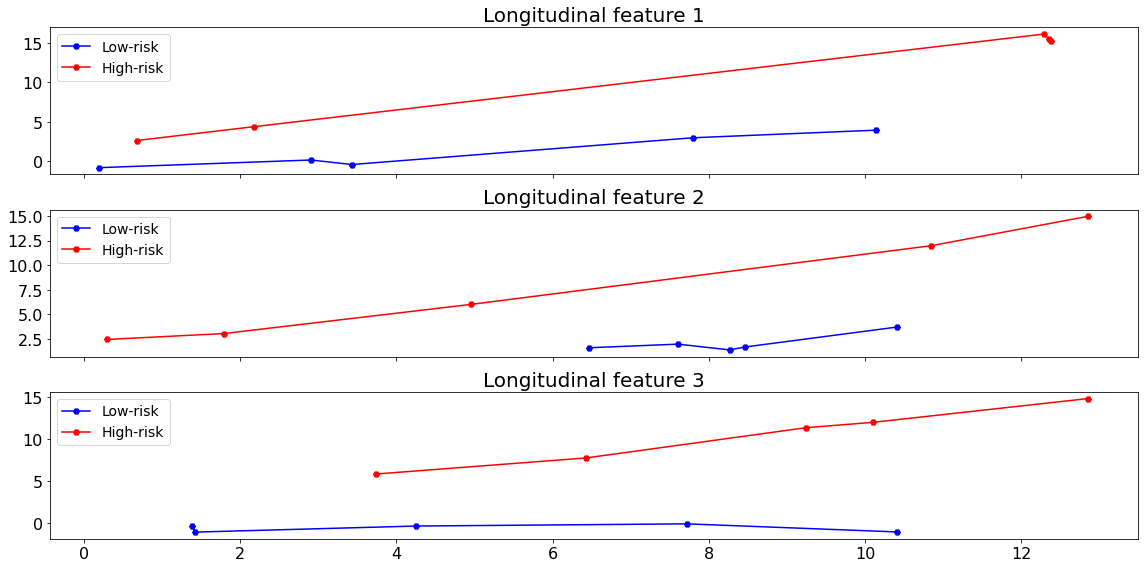

In [7]:
np.random.seed(10)
fig = plt.figure(figsize=(16, 8))
ax0 = plt.subplot(n_long_features,1,1)
colors, labels = ['b', 'r'], ['Low-risk', 'High-risk']
for k in [0, 1]:
    idx = np.random.choice(Y[G == k].index)
    Y_i = Y.loc[idx, :]
    label, color = labels[k], colors[k]
    for l in range(1, n_long_features + 1):
        Y_il = Y_i["long_feature_%s" % l]
        ax = plt.subplot(n_long_features,1 ,l , sharex=ax0)
        Y_il.plot(label=label, color=color, marker='H')
        ax.set_title("Longitudinal feature %s" % l, fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

### Visualize Hawkes Processes used to generate time measurements of longitudinal data for the previous high-risk subject

For a subject $i$, times $\{t_{ij}^l\}_{j \geq 1}$ for processes $l=1, \ldots, L$ are simulated using a multivariate Hawkes process $N_{it} = [N_{it}^1 \cdots N_{it}^L]$ with $t \geq 0$ and $N_{it}^l = \sum_{j \geq 1} 1_{\{t_{ij}^l \leq t\}}$. The process $N_{it}$ is a multivariate counting process, whose components $N_{it}^l$ have intensities
$$\lambda_i^l(t) = \Upsilon_{l} + \sum_{l'=1}^L \sum_{j \geq 1} A_{ll'} \upsilon \exp\big(-\upsilon(t - t_{ij}^{l'}) \big)$$
for $l=1, \ldots, L$.

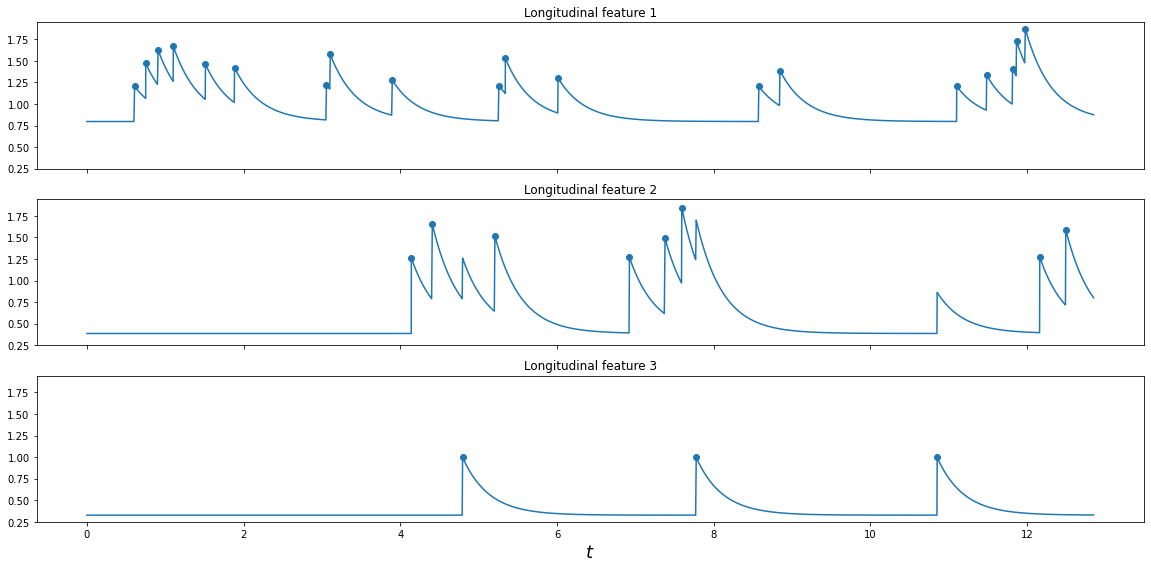

In [8]:
hawkes = simu.hawkes
hawkes_i = hawkes[idx]
adjacency = hawkes_i.adjacency

# need to reset hawkes to track intensity
hawkes_i.reset()
dt = 0.01
hawkes_i.track_intensity(dt)
hawkes_i.simulate()

fig, ax = plt.subplots(n_long_features, 1, figsize=(16, 8), sharex=True, sharey=True)
long_features_names = ["Longitudinal feature %s" % (l + 1) for l in range(n_long_features)]
plot_point_process(hawkes_i, n_points=50000, ax=ax, node_names=long_features_names)
fig.tight_layout()

The matrix $A = [A_{ll'}]_{1 \leq l,l' \leq L}$ is the adjacency matrix such that $A_{ll'} \geq 0$ quantifies the impact of past measurement time of process $l'$ on the measurement time of process $l$, and $\upsilon \geq 0$ is a memory parameter.

We also plot the density of the law used to simulate $t_i^{max}$, that is
$$t_i^{max} \sim T_i \times \big(1 - \text{Beta}(\nu_1, \nu_2)\big)$$
with $(\nu_1, \nu_2) = (2,5)$, to mimic the fact that in practice, one has access to a reasonable amount of longitudinal data before making a prediction.

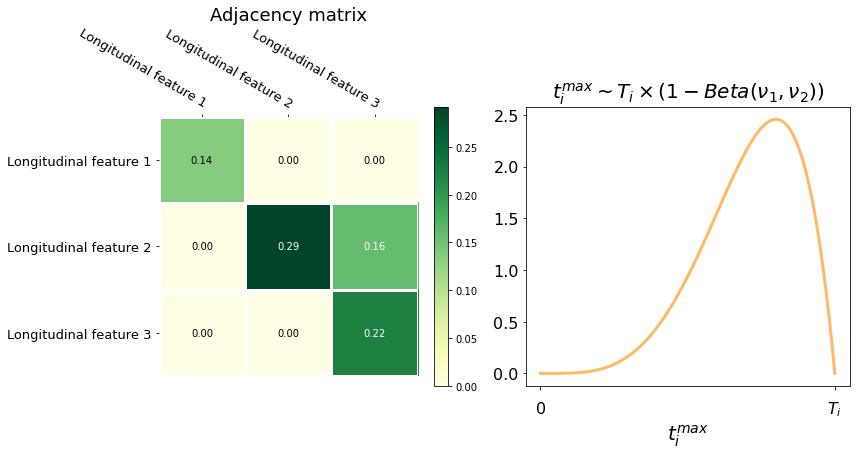

In [9]:
fig = plt.figure(figsize=(12, 6))
# Adjacency matrix
ax = fig.add_subplot(121)
im, cbar = heatmap(adjacency, long_features_names, long_features_names, ax=ax, cmap="YlGn")
texts = annotate_heatmap(im)
plt.title("Adjacency matrix", size=fontsize+2)

# Density of the law for the time up to which one has longitudinal data
ax = fig.add_subplot(122)
a, b = 2, 5
x = np.linspace(beta.ppf(0.0, a, b),
                beta.ppf(1, a, b), 100)
ax.plot(x, beta.pdf(1-x, a, b), '-', color='darkorange', lw=3, alpha=0.6)
labels = ['', r'$0$', r"$T_i$"]
plt.xlabel(r"$t_i^{max}$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.tick_params(axis='x', pad=10)
plt.title(r"$t_i^{max} \sim T_i \times (1 - Beta(\nu_1, \nu_2)) $", size=fontsize+4)
plt.locator_params(axis='x', nbins=2)
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

# Lights learning

## Initializer illustration

Since our QNMCEM algorithm gives a local minimum, it is clever to choose an initial value $\theta^{(0)}$ close to the final solution $\hat \theta$, so that the number of iterations required to reach convergence is reduced.

The longitudinal submodels parameters $\beta_k^{(0)}$, $D^{(0)}$ and $\phi^{(0)}$ are initialized (like if there is no subgroup ($\beta_0^{(0)} = \beta_{1}^{(0)}$)) using a multivariate linear mixed model (MLMM) with an explicit EM algorithm, being itself initialized with univariates fits (ULMM). Let us test those initializer on a simple example.

### Simulation with no latent subgroups

In [10]:
from lights.init.mlmm import MLMM
from lights.base.base import extract_features
from lights.base.utils import plot_history

# high_risk_rate=0 for no subgroups
simu_ = SimuJointLongitudinalSurvival(n_samples=300, n_time_indep_features=5,
                                      n_long_features=3, seed=1, high_risk_rate=0)
Y_ = simu_.simulate()[1]
# Get true beta parameter
true_beta_ = simu_.fixed_effect_coeffs[0]

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.40e+00 seconds.


### MLMM with fixed initialization

For instance $\beta^{(0)}=\textbf{0}$

Launching the solver MLMM...
 n_iter  |   obj    | rel_obj 
       0 |  7658.18 |      inf
      10 |  5308.64 | 9.69e-04
      20 |  5274.53 | 5.46e-04
      30 |  5246.93 | 5.18e-04
      40 |  5219.78 | 5.19e-04
      50 |  5192.95 | 5.09e-04
      60 |  5167.56 | 4.71e-04
      70 |  5145.06 | 4.05e-04
      80 |  5126.52 | 3.25e-04
      90 |  5112.04 | 2.50e-04
     100 |  5100.97 | 1.92e-04
     110 |  5092.39 | 1.51e-04
     120 |  5085.52 | 1.24e-04
     130 |  5079.76 | 1.06e-04
     140 |  5074.75 | 9.37e-05
     150 |  5070.24 | 8.53e-05
     160 |   5066.1 | 7.91e-05
     170 |  5062.24 | 7.41e-05
     180 |  5058.61 | 6.98e-05
     190 |  5055.19 | 6.58e-05
     200 |  5051.97 | 6.21e-05
     210 |  5048.94 | 5.85e-05
     220 |  5046.08 | 5.49e-05
     230 |  5043.41 | 5.14e-05
     240 |  5040.92 | 4.80e-05
     250 |  5038.59 | 4.47e-05
     260 |  5036.43 | 4.15e-05
     270 |  5034.42 | 3.85e-05
     280 |  5032.56 | 3.56e-05
     290 |  5030.85 | 3.29e-05
     300 |

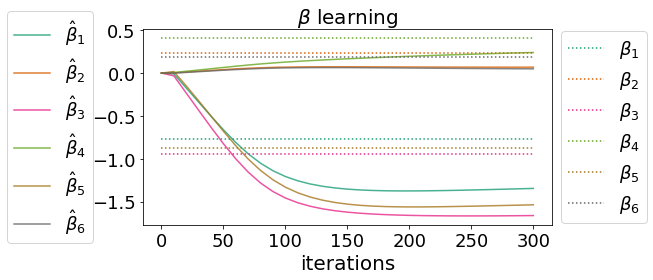

In [11]:
fixed_effect_time_order = 1
tol = 1e-5
mlmm = MLMM(fixed_effect_time_order=fixed_effect_time_order, 
            tol=tol, initialize=False, max_iter=300)
# Get design features matrices
extracted_features = extract_features(Y_, fixed_effect_time_order)
# Train the initializer
mlmm.fit(extracted_features)

# Visualize learning
to = len(true_beta_)+1
leg1 = [r"$\hat \beta_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta_%s$" % j for j in range(1, to)]
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta_, leg1, leg2)

### MLMM with ULMM initialization

<span style="color:crimson">**Convergence is faster, and the estimation much better**</span>

Launching the solver MLMM...
Launching the solver ULMM...


/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Done solving using ULMM in 1.50e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  6302.07 |      inf
       5 |  4882.28 | 2.94e-03
      10 |  4856.02 | 5.29e-04
      15 |  4849.13 | 1.86e-04
      20 |  4846.23 | 8.86e-05
      25 |  4844.71 | 5.00e-05
      30 |  4843.79 | 3.13e-05
      35 |  4843.19 | 2.11e-05
      40 |  4842.78 | 1.49e-05
      45 |  4842.48 | 1.10e-05
Done solving using MLMM in 5.66e+00 seconds


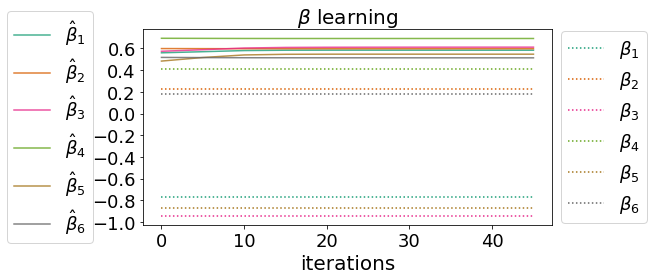

In [12]:
mlmm = MLMM(fixed_effect_time_order=fixed_effect_time_order, 
            print_every=5, tol=tol, initialize=True)
extracted_features = extract_features(Y_, fixed_effect_time_order)
mlmm.fit(extracted_features)
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta_, leg1, leg2)

In [13]:
# True covariance of random effect
true_long_cov = simu.long_cov
print("True of covariance of random effect", true_long_cov)
# Estimation of covariance of random effect
est_long_cov = mlmm.long_cov
print("Estimatation of covariance of random effect", est_long_cov)

True of covariance of random effect [[1.e-02 1.e-05 1.e-08 1.e-11 1.e-14 1.e-17]
 [1.e-05 1.e-02 1.e-05 1.e-08 1.e-11 1.e-14]
 [1.e-08 1.e-05 1.e-02 1.e-05 1.e-08 1.e-11]
 [1.e-11 1.e-08 1.e-05 1.e-02 1.e-05 1.e-08]
 [1.e-14 1.e-11 1.e-08 1.e-05 1.e-02 1.e-05]
 [1.e-17 1.e-14 1.e-11 1.e-08 1.e-05 1.e-02]]
Estimatation of covariance of random effect [[1.61407259 0.43987855 1.91884728 0.33357447 1.73813136 0.39193607]
 [0.43987855 0.12802497 0.53400805 0.09019058 0.47571849 0.10795485]
 [1.91884728 0.53400805 2.34245723 0.39986157 2.09717887 0.47889846]
 [0.33357447 0.09019058 0.39986157 0.07781352 0.35910645 0.0813957 ]
 [1.73813136 0.47571849 2.09717887 0.35910645 1.9660321  0.43569681]
 [0.39193607 0.10795485 0.47889846 0.0813957  0.43569681 0.10674467]]


## Data splitting

In [14]:
# Split data into training and test sets 
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    Y_test = Y.iloc[test_index, :]
    T_test = T[test_index]
    delta_test = delta[test_index]

    X_train = X[train_index]
    Y_train = Y.iloc[train_index, :]
    T_train = T[train_index]
    delta_train = delta[train_index]
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Training 

Launching the solver QNMCEM...
Launching the solver MLMM...
Launching the solver ULMM...


/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Done solving using ULMM in 1.53e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  6142.85 |      inf
       1 |  4919.82 | 1.99e-01
       2 |  4775.63 | 2.93e-02
       3 |  4738.92 | 7.69e-03
       4 |  4722.12 | 3.55e-03
       5 |  4712.48 | 2.04e-03
       6 |   4706.4 | 1.29e-03
       7 |  4702.31 | 8.68e-04
       8 |  4699.44 | 6.11e-04
       9 |  4697.34 | 4.47e-04
      10 |  4695.76 | 3.37e-04
Done solving using MLMM in 2.51e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  46.3249 |      inf
       1 |  39.0245 | 1.58e-01
       2 |  28.2991 | 2.75e-01
       3 |   24.367 | 1.39e-01
       4 |  23.9403 | 1.75e-02
       5 |  23.5841 | 1.49e-02
       6 |  23.2548 | 1.40e-02
       7 |  24.2079 | 4.10e-02
       8 |  24.0371 | 7.06e-03
       9 |  23.9381 | 4.12e-03
      10 |  23.8585 | 3.32e-03
Done solving using QNMCEM in 6.86e+02 seconds


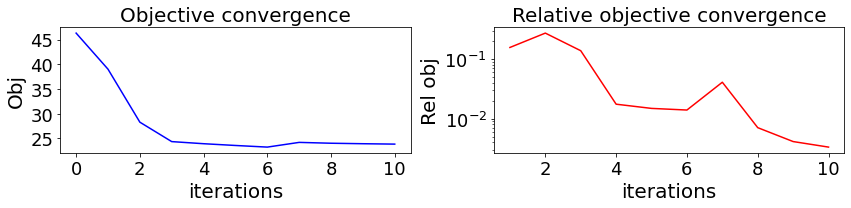

In [15]:
from lights.inference import QNMCEM

## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

qnmcem = QNMCEM(fixed_effect_time_order=1, max_iter=10, compute_obj=True, print_every=1,
               l_pen_SGL=conf["l_pen_SGL"], eta_sp_gp_l1=.9, asso_functions=["lp", "re", "tps"],
               l_pen_EN=conf["l_pen_EN"], initialize=True)
qnmcem.fit(X_train, Y_train, T_train, delta_train)

# Visualize learning
visualize_vect_learning(qnmcem, "obj")

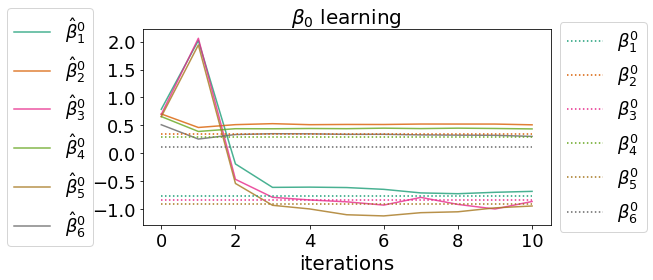

In [16]:
# Visualize beta_0
true_beta_0 = simu.fixed_effect_coeffs[0].reshape(-1, 1)
to = len(true_beta_0)+1
leg1 = [r"$\hat \beta^0_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^0_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "beta_0", r"$\beta_0$", true_beta_0, leg1, leg2)

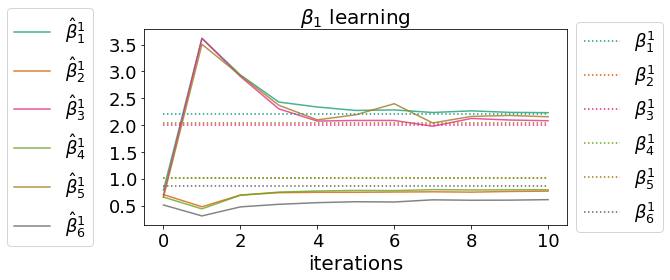

In [17]:
# Visualize beta_1
true_beta_1 = simu.fixed_effect_coeffs[1].reshape(-1, 1)
to = len(true_beta_1)+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "beta_1", r"$\beta_1$", true_beta_1, leg1, leg2)

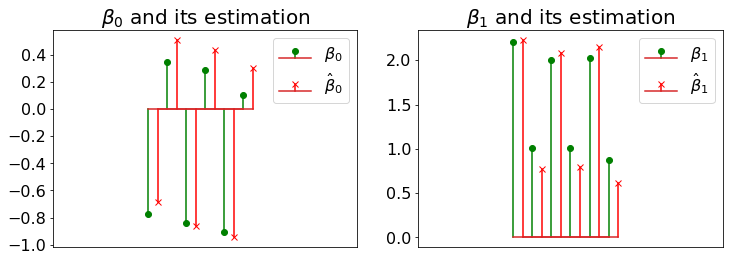

In [18]:
beta_0_true = true_beta_0
beta_0_est = qnmcem.theta["beta_0"]
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(beta_0_true)).tolist(), beta_0_true, linefmt='g-', markerfmt='go', label= r"$\beta_0$")
ax.stem((np.arange(len(beta_0_est)) + .5).tolist(), beta_0_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_0$")
ax.set_xlim([-5, len(beta_0_true) + 5])
ax.set_title(r"$\beta_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)

beta_1_true = true_beta_1
beta_1_est = qnmcem.theta["beta_1"]
fontsize = 16
ax = fig.add_subplot(122)
ax.stem(np.arange(len(beta_1_true)).tolist(), beta_1_true, linefmt='g-', markerfmt='go', label= r"$\beta_1$")
ax.stem((np.arange(len(beta_1_est)) + .5).tolist(), beta_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_1$")
ax.set_xlim([-5, len(beta_1_true) + 5])
ax.set_title(r"$\beta_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

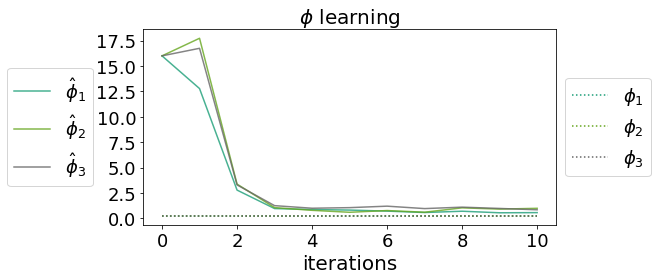

In [19]:
# Visualize phi
true_phi = np.array([simu.std_error ** 2] * simu.n_long_features).reshape(-1, 1)
to = len(true_phi)+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "phi", symbol = r"$\phi$", true_coeffs = true_phi, legend_est = leg1, legend_true = leg2)

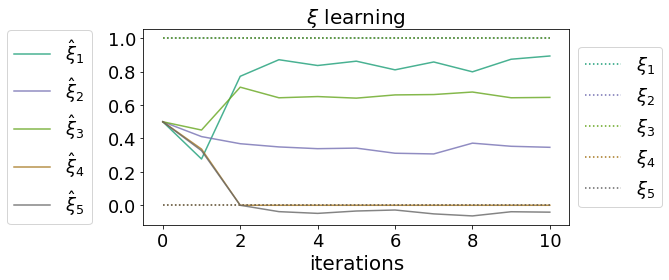

In [20]:
# Visualize xi
true_xi = simu.time_indep_coeffs.reshape(-1, 1)
to = len(true_xi)+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "xi", r"$\xi$", true_xi, leg1, leg2)

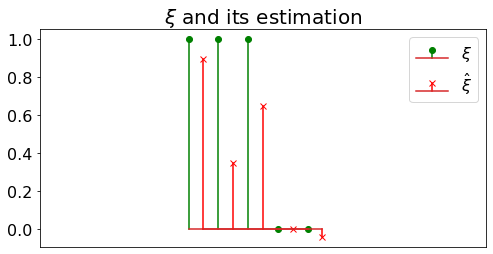

In [21]:
xi_true = true_xi
xi_est = qnmcem.theta["xi"]
fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(np.arange(len(xi_true)).tolist(), true_xi, linefmt='g-', markerfmt='go', label= r"$\xi$")
ax.stem((np.arange(len(xi_est)) + .5).tolist(), xi_est, linefmt='r-', markerfmt='rx', label= r"$\hat \xi$")
ax.set_xlim([-5, len(true_xi) + 5])
ax.set_title(r"$\xi$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

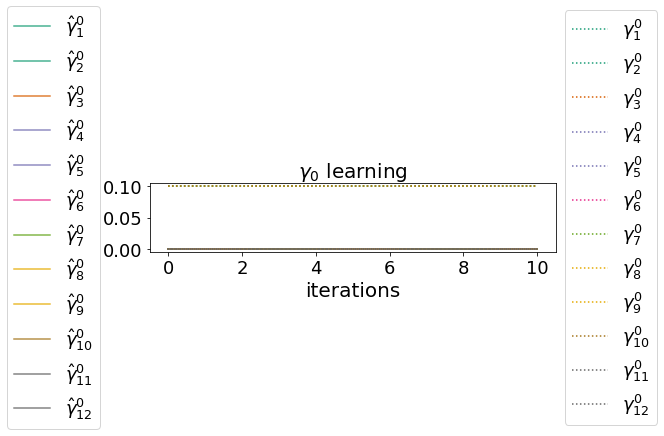

In [22]:
# Visualize gamma_0
true_gamma_0 = simu.asso_coeffs[0].reshape(-1, 1)
to = len(true_gamma_0)+1
leg1 = [r"$\hat \gamma^0_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^0_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "gamma_0", r"$\gamma_0$", true_gamma_0, leg1, leg2)

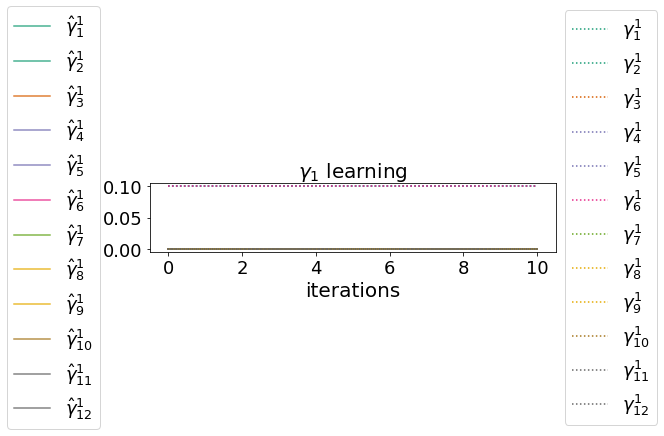

In [23]:
# Visualize gamma_1
true_gamma_1 = simu.asso_coeffs[1].reshape(-1, 1)
to = len(true_gamma_1)+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "gamma_1", r"$\gamma_1$", true_gamma_1, leg1, leg2)

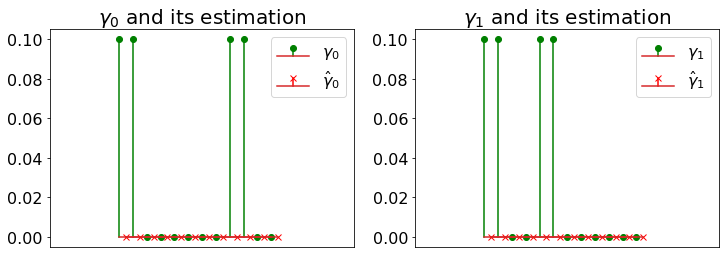

In [24]:
gamma_0_true = true_gamma_0
gamma_0_est = qnmcem.theta["gamma_0"]
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(gamma_0_true)).tolist(), gamma_0_true, linefmt='g-', markerfmt='go', label= r"$\gamma_0$")
ax.stem((np.arange(len(gamma_0_est)) + .5).tolist(), gamma_0_est, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_0$")
ax.set_xlim([-5, len(true_gamma_0) + 5])
ax.set_title(r"$\gamma_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)

gamma_1_true = true_gamma_1
gamma_1_est = qnmcem.theta["gamma_1"]
ax = fig.add_subplot(122)
ax.stem(np.arange(len(gamma_1_true)).tolist(), gamma_1_true, linefmt='g-', markerfmt='go', label= r"$\gamma_1$")
ax.stem((np.arange(len(gamma_1_est)) + .5).tolist(), gamma_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_1$")
ax.set_xlim([-5, len(true_gamma_1) + 5])
ax.set_title(r"$\gamma_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

In [25]:
# Check estimated covariance of random effect
qnmcem.theta["long_cov"]

array([[ 3.55982308e-03, -2.19441253e-04, -3.42857286e-04,
         9.24561577e-05, -1.89766162e-03,  2.84318161e-03],
       [-2.19441253e-04,  4.79135737e-02, -1.18663200e-02,
         3.94597262e-02, -1.62485217e-02,  4.67480114e-02],
       [-3.42857286e-04, -1.18663200e-02,  5.45154004e-03,
        -6.76207095e-03,  6.23831024e-03, -6.77112810e-03],
       [ 9.24561577e-05,  3.94597262e-02, -6.76207095e-03,
         4.16565344e-02, -1.16483021e-02,  4.65317543e-02],
       [-1.89766162e-03, -1.62485217e-02,  6.23831024e-03,
        -1.16483021e-02,  8.86931330e-03, -1.27905345e-02],
       [ 2.84318161e-03,  4.67480114e-02, -6.77112810e-03,
         4.65317543e-02, -1.27905345e-02,  6.05037621e-02]])

### Note
* Currently, for debugging phase, just run first two cells and move to "Training" cell to run QNMCEM algorithm
* Call the QNMCEM function to run experiments with different setting (l_pen, max_iter, copt_accelerate, ...)

## Prediction

In [26]:
## Obtain the marker vector on test set ##

# prediction here

#c_index = c_index_score(Y_test, marker, delta_test)
#c_index = max(c_index, 1 - c_index)

print("Done predicting on test set.")
#print("C-index : %.2f" % c_index)

Done predicting on test set.


## Figures

### Learning curves

### Convergence

### Beta coefficients